In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib notebook

In [2]:
a = 0.01

### Numerical solver

In [3]:
def concentration_tree(d, cfrac_c1frac_smfrac_m1frac_e1frac):
    
    """
    d = total protein
    
    Concentrations described by a series of fractions (0-1)
    
    c (cfrac)
        c1 (c1frac)
        c2
    s
        m (smfrac)
            m1 (m1frac)
            m2
        e
            e1 (e1frac)
            e2

    """
    
    cfrac, c1frac, smfrac, m1frac, e1frac = [1 / (1 + np.exp(- i)) for i in cfrac_c1frac_smfrac_m1frac_e1frac]
    c = d * cfrac
    s = d * (1 - cfrac)
    m = s * smfrac * (1 / (0.1 * a))
    e = s * (1 - smfrac) * (1 / (0.1 * a))  
    c1 = c * c1frac
    c2 = (c - c1) #/ 2   
    m1 = m * m1frac
    m2 = (m - m1) #/ 2 
    e1 = e * e1frac
    e2 = (e - e1) #/ 2
    return c1, c2, m1, m2, e1, e2

In [4]:
def calc_loss(cfrac_c1frac_smfrac_m1frac_e1frac, d, wd, wm, we):

    # Concentrations
    c1, c2, m1, m2, e1, e2 = concentration_tree(d, cfrac_c1frac_smfrac_m1frac_e1frac)
        
    # Enthalpic terms
    wc1 = 0
    wc2 = wd
    wm1 = wm
    wm2 = 2 * wm + wd
    we1 = we
    we2 = 2 * we + wd

    # Chemical potentials
    muc1 = np.log(c1) - wc1
    muc2 = np.log(c2) - wc2
    mum1 = np.log(m1) - wm1
    mum2 = np.log(m2) - wm2
    mue1 = np.log(e1) - we1
    mue2 = np.log(e2) - we2

    # Loss
    mu_all = np.array([2 * muc1, muc2, 2 * mum1, mum2, 2 * mue1, mue2])
    loss = np.sum((mu_all[:, np.newaxis] - mu_all[np.newaxis, :]) ** 2)
        
    return loss

### Titrating wd for different wi

In [5]:
def panel(ax, wm=5, we=0, log_d=-5): 
    
    n = 100
    wds = np.linspace(0, 20, n)
    res_c = np.zeros(n)
    res_m = np.zeros(n)
    res_e = np.zeros(n)
    
    d = 10 ** log_d
    for i, wd in enumerate(wds):
        # Optimise
        x0 = [0, 0, 0, 0, 0]
        res = minimize(calc_loss, x0=x0, args=(d, wd, wm, we)).x

        # Get concentrations
        c1, c2, m1, m2, e1, e2 = concentration_tree(d, res)
        c_tot = c1 + 1 * c2
        m_tot = (m1 + 1 * m2) * 0.1 * a
        e_tot = (e1 + 1 * e2) * 0.1 * a
        
        # Save concentrations
        res_c[i] = c_tot / d
        res_m[i] = m_tot / d
        res_e[i] = e_tot / d
    
    # Plot
    ax.clear()
    ax.plot(wds, res_c, label='Cytoplasm')
    ax.plot(wds, res_m, label='Plasma membrane')
    ax.plot(wds, res_e, label='Internal membranes')

    ax.set_title("$w_i$ = %s" % we, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_xlabel("$w_d$")
    ax.set_ylabel('Fraction')
    ax.tick_params(axis='both', labelsize=8)

<IPython.core.display.Javascript object>


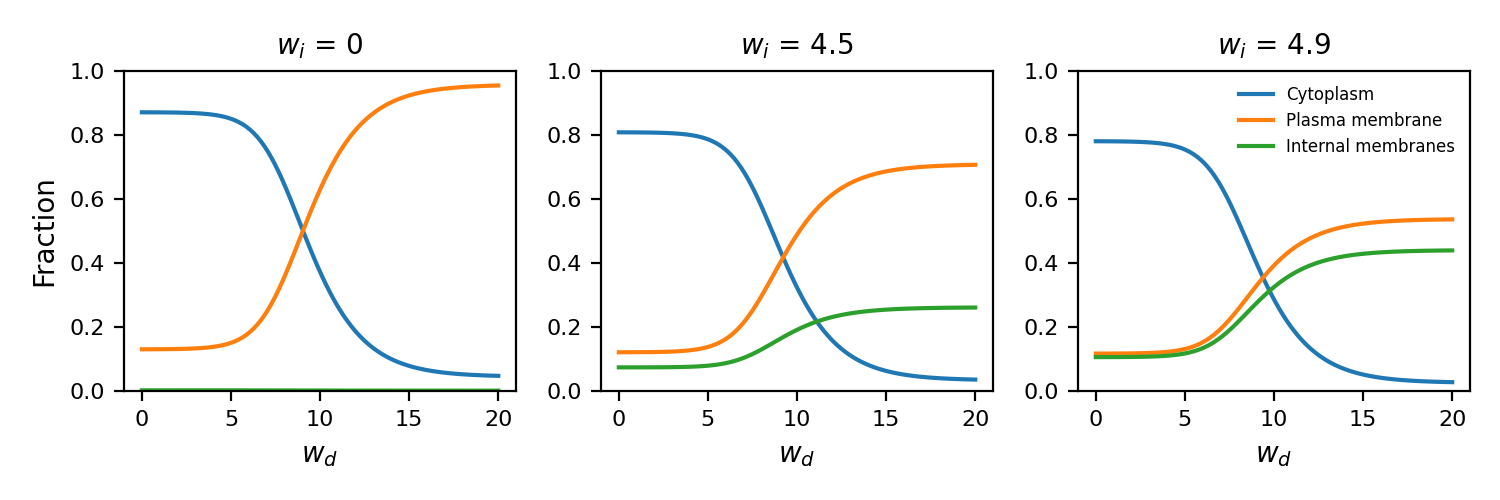

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

panel(ax1, wm=5, we=0, log_d=-5)
panel(ax2, wm=5, we=4.5, log_d=-5)
panel(ax3, wm=5, we=4.9, log_d=-5)

ax2.set_ylabel('')
ax3.set_ylabel('')
# ax2.set_yticks([])
# ax3.set_yticks([])
ax3.legend(frameon=False, fontsize=6)

fig.set_size_inches(7.5, 2.5)
fig.tight_layout()
fig.savefig('Figs_three_surface/six_state_thermodynamic.png', dpi=600, transparent=True)